<a href="https://colab.research.google.com/github/ali-talebi/norouz1404/blob/main/KL_EX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

در حال تولید داده‌ها...
ابعاد داده‌ها: Train (256, 64, 64, 1), IC (256, 64, 64, 1), OC (256, 64, 64, 1)
در حال آموزش مدل VAE...
Epoch 1/50 - Recon Loss: 0.2282 - KL Loss: 0.0003
Epoch 11/50 - Recon Loss: 0.0610 - KL Loss: 0.0000
Epoch 21/50 - Recon Loss: 0.0610 - KL Loss: 0.0000
Epoch 31/50 - Recon Loss: 0.0610 - KL Loss: 0.0000
Epoch 41/50 - Recon Loss: 0.0610 - KL Loss: 0.0000
Epoch 50/50 - Recon Loss: 0.0610 - KL Loss: 0.0000
در حال محاسبه خطای بازسازی...
حد کنترل بالایی (UCL) = 0.073734


IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

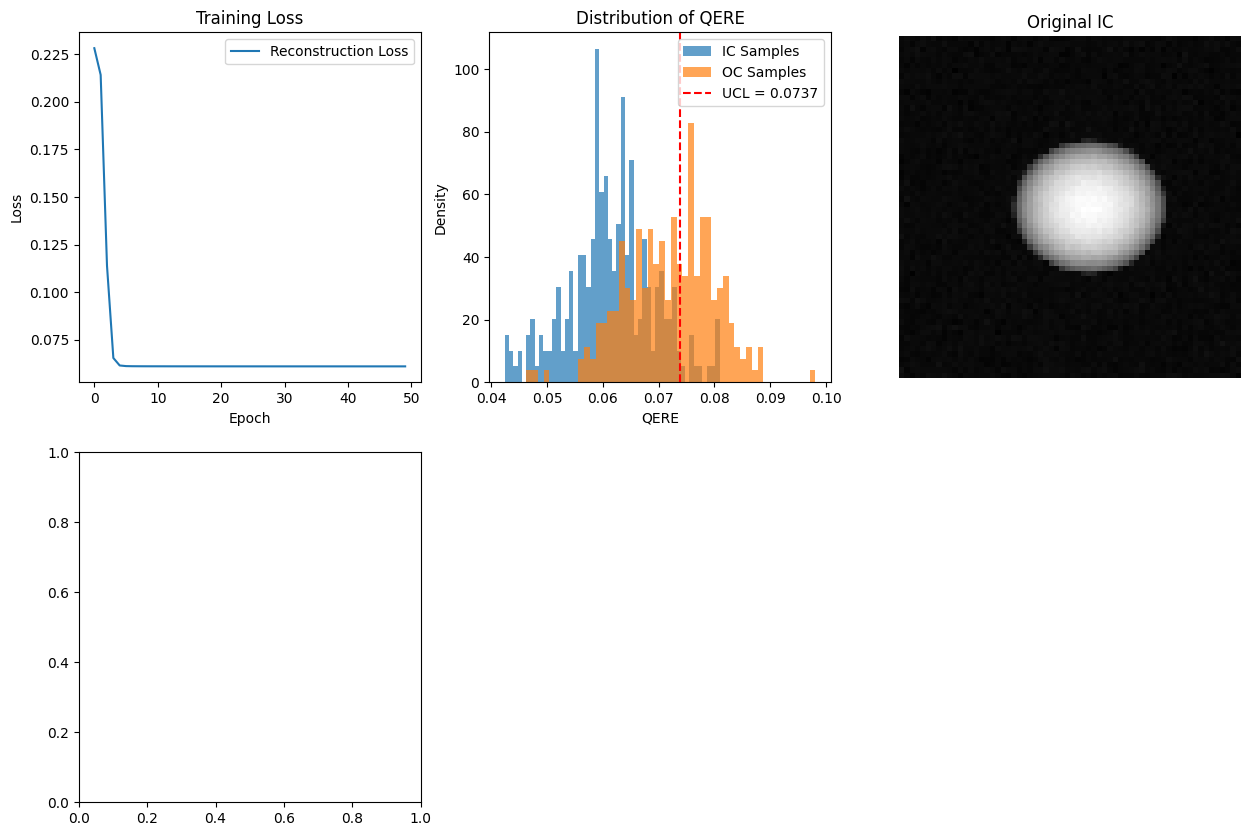

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------
# 1. تنظیمات
# --------------------------------------------------------------------------------------------------
IMG_SIZE = 64
LATENT_DIM = 2
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

# شبکه فضایی
GRID = np.linspace(0, 1, IMG_SIZE)
P0, P1 = np.meshgrid(GRID, GRID)

print("در حال تولید داده‌ها...")

# --------------------------------------------------------------------------------------------------
# 2. تولید داده‌های شبیه‌سازی شده (مطابق مقاله)
# --------------------------------------------------------------------------------------------------
def generate_gasket(c0, a, noise_std=0.01):
    b = 0.2   # پهنای عمودی
    c1 = 0.5  # مرکز عمودی
    g = 1 - ((P0 - c0)/a)**2 - ((P1 - c1)/b)**2
    f = np.sqrt(np.maximum(g, 0))
    noise = np.random.normal(0, noise_std, f.shape)
    return f + noise

def create_dataset(n_samples, oc_shift=None):
    # تولید داده‌های IC
    c0_samples = np.random.normal(0.5, np.sqrt(1e-2), n_samples)
    a_samples = np.random.normal(0.2, np.sqrt(6.25e-4), n_samples)

    if oc_shift is not None:
        c0_samples += oc_shift[0] * 1e-1
        a_samples += oc_shift[1] * 2.5e-2

    images = np.array([generate_gasket(c0, a) for c0, a in zip(c0_samples, a_samples)])
    return images[..., np.newaxis]  # (N, 64, 64, 1)

# تولید داده‌ها
X_train = create_dataset(256)
X_test_ic = create_dataset(256)
X_test_oc = create_dataset(256, oc_shift=(0, 1.5))  # OC: Width Shift

print(f"ابعاد داده‌ها: Train {X_train.shape}, IC {X_test_ic.shape}, OC {X_test_oc.shape}")

# --------------------------------------------------------------------------------------------------
# 3. ساخت مدل VAE (Encoder + Decoder)
# --------------------------------------------------------------------------------------------------
# Encoder
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 4, strides=2, padding='same')(encoder_inputs)
x = layers.ReLU()(x)
x = layers.Conv2D(32, 4, strides=2, padding='same')(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 4, strides=1, padding='same')(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

z_mean = layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Reshape((1, 1, 256))(x)
x = layers.Conv2DTranspose(64, 4, strides=1, padding='valid', activation='relu')(x)
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, x, name='decoder')

# تابع بازسازی
def reconstruct(x):
    z_mean, z_log_var, z = encoder(x)
    return decoder(z)

# --------------------------------------------------------------------------------------------------
# 4. آموزش دستی با GradientTape (بدون fit(), بدون loss, بدون add_loss)
# --------------------------------------------------------------------------------------------------
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        # Forward pass
        z_mean, z_log_var, z = encoder(x)
        x_recon = decoder(z)

        # Reconstruction loss (MSE)
        recon_loss = tf.reduce_mean(tf.square(x - x_recon))

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        # Total loss
        total_loss = recon_loss + kl_loss

    # محاسبه و آپدیت گرادیان‌ها
    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

    return recon_loss, kl_loss, total_loss

# آموزش
print("در حال آموزش مدل VAE...")
recon_losses = []
kl_losses = []

for epoch in range(EPOCHS):
    epoch_recon = 0.0
    epoch_kl = 0.0
    num_batches = 0

    for i in range(0, len(X_train), BATCH_SIZE):
        batch = X_train[i:i+BATCH_SIZE]
        batch = tf.constant(batch, dtype=tf.float32)

        r_loss, k_loss, _ = train_step(batch)
        epoch_recon += r_loss
        epoch_kl += k_loss
        num_batches += 1

    epoch_recon /= num_batches
    epoch_kl /= num_batches
    recon_losses.append(epoch_recon)
    kl_losses.append(epoch_kl)

    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch {epoch+1}/{EPOCHS} - Recon Loss: {epoch_recon:.4f} - KL Loss: {epoch_kl:.4f}")

# --------------------------------------------------------------------------------------------------
# 5. محاسبه QERE (خطای بازسازی)
# --------------------------------------------------------------------------------------------------
def calculate_qere(x):
    x = tf.constant(x, dtype=tf.float32)
    z_mean, z_log_var, z = encoder(x)
    x_recon = decoder(z)
    qere = np.mean(np.square(x.numpy() - x_recon.numpy()), axis=(1, 2, 3))
    return qere, x_recon.numpy()

print("در حال محاسبه خطای بازسازی...")
qere_ic, recon_ic = calculate_qere(X_test_ic)
qere_oc, recon_oc = calculate_qere(X_test_oc)

# تعیین حد کنترل (UCL) از داده‌های IC
UCL = np.percentile(qere_ic, 95)
print(f"حد کنترل بالایی (UCL) = {UCL:.6f}")

# --------------------------------------------------------------------------------------------------
# 6. نمایش نتایج
# --------------------------------------------------------------------------------------------------
plt.figure(figsize=(15, 10))

# نمودار 1: تاریخچه آموزش
plt.subplot(2, 3, 1)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# نمودار 2: توزیع QERE
plt.subplot(2, 3, 2)
plt.hist(qere_ic, bins=50, alpha=0.7, label='IC Samples', density=True)
plt.hist(qere_oc, bins=50, alpha=0.7, label='OC Samples', density=True)
plt.axvline(UCL, color='red', linestyle='--', label=f'UCL = {UCL:.4f}')
plt.title('Distribution of QERE')
plt.xlabel('QERE')
plt.ylabel('Density')
plt.legend()

# نمودار 3: نمونه IC اصلی
plt.subplot(2, 3, 3)
plt.imshow(X_test_ic[0, :, :, 0], cmap='gray')
plt.title('Original IC')
plt.axis('off')

# نمودار 4: بازسازی IC
plt.subplot(2, 3, 4)
plt.imshow(recon_ic[0, 0, :, :, 0], cmap='gray')
plt.title('Reconstructed IC')
plt.axis('off')

# نمودار 5: نمونه OC اصلی
plt.subplot(2, 3, 5)
plt.imshow(X_test_oc[0, :, :, 0], cmap='gray')
plt.title('Original OC')
plt.axis('off')

# نمودار 6: بازسازی OC
plt.subplot(2, 3, 6)
plt.imshow(recon_oc[0, 0, :, :, 0], cmap='gray')
plt.title('Reconstructed OC')
plt.axis('off')

plt.tight_layout()
plt.show()

# چاپ آمار
print(f"\nآمار خطای بازسازی:")
print(f"میانگین QERE (IC): {np.mean(qere_ic):.6f}")
print(f"میانگین QERE (OC): {np.mean(qere_oc):.6f}")
print(f"نرخ تشخیص OC (Power): {np.mean(qere_oc > UCL):.3f}")
print(f"نرخ آلارم کاذب (FAR): {np.mean(qere_ic > UCL):.3f}")